## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:

    users = df['user_id'].unique().max() + 1
    items = df['item_id'].unique().max() + 1

    result = np.zeros((users, items))

    for _, row in df.iterrows():
        result[row['user_id'], row['item_id']] = row['rating']

    return result

In [10]:
interactions = df_to_matrix(df_train)

In [11]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:

    users = df['user_id'].unique().max() + 1
    items = df['item_id'].unique().max() + 1

    result = np.zeros((users, items))

    for _, row in df.iterrows():
        result[row['user_id'], row['item_id']] = row['rating']

    return coo_array(result)

In [12]:
coo_interactions = df_to_coo(df_train)

In [13]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [14]:
from numpy.linalg import svd
from scipy.sparse.linalg import svds

def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    if isinstance(interactions, np.ndarray):
        U, S, V = svd(interactions, full_matrices=False)
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = np.diag(S[:n_singular_values])
            V = V[:n_singular_values, :]
        else:
            S = np.diag(S)
    #проверка на sparse матрицу
    elif isinstance(interactions, coo_array):
        if n_singular_values == -1:
            n_singular_values = min(interactions.shape) - 1
        U, S, V = svds(interactions, k=n_singular_values)
        S = np.diag(S)
    else:
        raise ValueError("Unsupported matrix type")

    return U, S, V

In [15]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [16]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [17]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    U, S, V = make_svd(interactions, n_singular_values)
    reconstructed_matrix = np.dot(U, np.dot(S, V))
    if isinstance(interactions, coo_array):
        interactions = interactions.toarray()

    recommendations = []
    for user_idx in range(reconstructed_matrix.shape[0]):
        user_interactions = interactions[user_idx]
        scores = reconstructed_matrix[user_idx]
        scores[user_interactions > 0] = -np.inf  # Исключаем уже взаимодействованные айтемы
        top_items = np.argsort(scores)[-top_k:][::-1]  # Выбираем top_k наибольших значений
        recommendations.append(top_items)

    return np.array(recommendations)

In [18]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [19]:
test_interactions = df_to_matrix(df_test)
test_coo_interactions = df_to_coo(df_test)

In [20]:
import time
import matplotlib.pyplot as plt

def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0
    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])
    if ideal_dcg == 0.0:
        return 0.0
    ndcg_ = rank_dcg / ideal_dcg
    return ndcg_

def dcg(scores):
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )

    return dcg / idcg if idcg > 0 else 0

def plot_graphs(train: Union[np.ndarray, coo_array], test: Union[np.ndarray, coo_array], top_k: int = 100):
    ndcg_scores = []
    times = []
    singular_values_list = [1, 10, 50, 200, 1000]
    if (isinstance(test, coo_array)):
        test = test.toarray()
    for n_singular in singular_values_list:
        start_time = time.time()
        recs = make_svd_recommendations(train, n_singular, 100)
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)

        true_relevance = test[np.arange(test.shape[0])[:, None], recs]
        ndcg = np.mean([ndcg_metric(true, rec) for true, rec in zip(true_relevance, recs)])
        ndcg_scores.append(ndcg)
    print(f"Максимальный NDSG: {max(ndcg_scores)}. Достигается при n_singular={singular_values_list[ndcg_scores.index(max(ndcg_scores))]}")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(singular_values_list, ndcg_scores, marker='o')
    plt.xlabel('Количество сингулярных значений')
    plt.ylabel('NDCG')
    plt.title('Зависимость NDCG от n_singular_values')

    plt.subplot(1, 2, 2)
    plt.plot(singular_values_list, times, marker='o')
    plt.xlabel('Количество сингулярных значений')
    plt.ylabel('Время выполнения (сек)')
    plt.title('Зависимость времени работы от n_singular_values')

    plt.show()

Максимальный NDSG: 0.6738507502740094. Достигается при n_singular=1


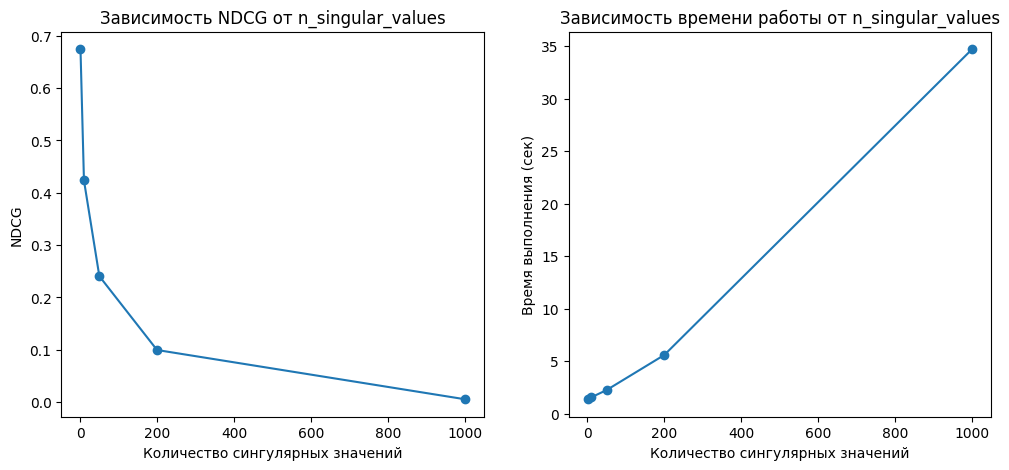

In [21]:
plot_graphs(coo_interactions, test_coo_interactions)

Как можно заметить самое лучшее значение метрики достигается при n=1 сингулярных значений (0.11). По графикам видно, что с увеличением n_singular_values метрика стремтилеьно ухудшается, а время увеличивается

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [ ]:
!pip install implicit

In [23]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix, coo_matrix

def make_als_recommendations(
    interractions: Union[np.ndarray, coo_array],
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    if isinstance(interractions, np.ndarray):
        interractions = coo_matrix(interractions)

    interactions = interractions.tocsr()
    # Применяем взвешивание alpha для неявных данных
    weighted_interactions = (interactions * alpha).astype(np.float32)

    # Обучаем модель ALS
    model = AlternatingLeastSquares(
        factors=n_factors,
        regularization=regularization,
        iterations=15,
        random_state=42
    )
    model.fit(weighted_interactions)

    # Генерируем рекомендации для всех пользователей
    user_ids = np.arange(interactions.shape[0])
    recommendations= np.array([
        model.recommend(user, weighted_interactions[user], N=top_k, filter_already_liked_items=True)[0]
        for user in user_ids
    ])

    return recommendations, model  # [n_users, top_k] #shape ~ [n_users, top_k]

In [24]:
recs, als = make_als_recommendations(interactions)
assert recs.shape == (interactions.shape[0], 100)

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [26]:
def explain_recommendations(
    model: AlternatingLeastSquares,
    interactions: csr_matrix,
    movie_titles: dict,
    user_id: int,
    top_n: int = 3
):
    """Объясняет топ-N рекомендаций для пользователя user_id"""

    if isinstance(interactions, np.ndarray):
        interactions = coo_matrix(interactions)

    interactions = interactions.tocsr()
    user_interactions = interactions[user_id]
    recommended_item_ids = model.recommend(user_id, user_interactions, N=top_n, filter_already_liked_items=True)[0]
    explanations = []
    print(f"Для юзера: {user_id}")
    for item_id in recommended_item_ids:
        # Получаем объяснение (вклад просмотренных фильмов)
        score, contributions, weights  = model.explain(user_id, interactions, item_id)
        # Формируем читаемый вывод
        item_name = movie_titles[movie_titles.movie_id == item_id].title.values[0]
        explained_text = f"\nРекомендованный фильм: {item_name} (Оценка: {score:.2f})"

        # Покажем топ-3 самых значимых фильмов, которые повлияли на рекомендацию
        top_contributors = sorted(contributions, key=lambda x: -x[1])[:3]
        explained_text += "\nНа рекомендацию повлияли:"
        for contrib_id, contrib_score in top_contributors:
            contrib_name = movie_titles[movie_titles.movie_id == contrib_id].title.values[0]
            explained_text += f"\n  - {contrib_name} (вклад: {contrib_score:.2f})"

        explanations.append(explained_text)

    return "\n".join(explanations) + "\n \n"

In [28]:
movie_titles = pd.read_csv("ml-1m/movies.dat", sep="::", names=["movie_id", "title", "genres"], engine="python", encoding="ISO-8859-1")
users = np.random.randint(0, 5365, 5)
for user_id in users:
    explanation_text = explain_recommendations(als, interactions, movie_titles, user_id)
    print(explanation_text)

Для юзера: 451

Рекомендованный фильм: Soul Man (1986) (Оценка: 0.90)
На рекомендацию повлияли:
  - Star Wars: Episode V - The Empire Strikes Back (1980) (вклад: 0.11)
  - Poison Ivy II (1995) (вклад: 0.10)
  - Up in Smoke (1978) (вклад: 0.08)

Рекомендованный фильм: Little Princess, A (1995) (Оценка: 0.90)
На рекомендацию повлияли:
  - Fear of a Black Hat (1993) (вклад: 0.19)
  - Farinelli: il castrato (1994) (вклад: 0.12)
  - Poetic Justice (1993) (вклад: 0.11)

Рекомендованный фильм: Rhyme & Reason (1997) (Оценка: 0.87)
На рекомендацию повлияли:
  - Devil's Advocate, The (1997) (вклад: 0.09)
  - Dangerous Ground (1997) (вклад: 0.08)
  - Singin' in the Rain (1952) (вклад: 0.08)
 

Для юзера: 2056

Рекомендованный фильм: Girls Town (1996) (Оценка: 0.85)
На рекомендацию повлияли:
  - Night of the Living Dead (1968) (вклад: 0.23)
  - Browning Version, The (1994) (вклад: 0.17)
  - Nothing to Lose (1994) (вклад: 0.17)

Рекомендованный фильм: When a Man Loves a Woman (1994) (Оценка: 0.69)


> **Вывод:**
- Модель `ALS` сначала генерирует список топ фильмов для каждого пользователя. Для каждого пользователя модель оценивает потенциальную релевантность всех фильмов, используя скрытые векторы пользователя и фильмов, и сортирует их по убыванию. При этом в рекомендациях исключаются фильмы, с которыми пользователь уже имел взаимодействие. Полученная оценка по итогу является суммарным значением, полученным в результате скалярного произведения скрытых факторов. По факту показывает насколько фильм соответствует предпочтениям конкретного пользователя.
- Метод `als.explain` показывает, какие из уже просмотренных фильмов пользователя больше всего повлияли на рекомендацию. Каждый вклад зависит от того, насколько похож этот просмотренный фильм на тот, который рекомендован, и насколько сильно пользователь его оценил. Затем выбираются три фильма с наибольшим вкладом, чтобы объяснить, почему именно этот фильм оказался в рекомендациях.

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [30]:
def transform_ratings(df, method, max_train_date=None, decay_factor=0.9):
    df = df.copy()
    if method == "binary":
        df["rating"] = 1
    elif method == "positive_only":
        df["rating"] = (df["rating"] >= 4).astype(int)
    elif method == "positive_negative":
        df["rating"] = np.where(df["rating"] >= 4, 1, -1)
    elif method == "time_decay":
        df["rating"] = np.where(df["rating"] >= 4, 1, -1)
        df["weight"] = df["datetime"].apply(lambda x: decay_factor ** ((max_train_date - x).days // 30))
        df["rating"] *= df["weight"]
    return df

methods = ["binary", "positive_only", "positive_negative", "time_decay"]
max_train_date = df_train["datetime"].max()

def evaluate_methods(df_train, df_test, methods, max_train_date):
    results = {}

    for method in methods:
        print(f"\nОбучение моделей для метода: {method}")
        transformed_df = transform_ratings(df_train, method, max_train_date)
        matrix_train = df_to_matrix(transformed_df)

        print("Обучаем SVD...")
        recs_svd = make_svd_recommendations(matrix_train, 1, 100)

        print("Обучаем ALS...")
        recs_als, als_model = make_als_recommendations(matrix_train)

        # Оценка качества рекомендаций
        true_relevance_als = test_coo_interactions.toarray()[np.arange(test_coo_interactions.shape[0])[:, None], recs_als]
        true_relevance_svd = test_coo_interactions.toarray()[np.arange(test_coo_interactions.shape[0])[:, None], recs_svd]
        ndcg_score_als = np.mean([ndcg_metric(true, rec) for true, rec in zip(true_relevance_als, recs_als)])
        ndcg_score_svd = np.mean([ndcg_metric(true, rec) for true, rec in zip(true_relevance_svd, recs_svd)])
        results[method] = [ndcg_score_svd, ndcg_score_als]

    return results
results = evaluate_methods(df_train, df_test, methods, max_train_date)


Обучение моделей для метода: binary
Обучаем SVD...
Обучаем ALS...


  0%|          | 0/15 [00:00<?, ?it/s]


Обучение моделей для метода: positive_only
Обучаем SVD...
Обучаем ALS...


  0%|          | 0/15 [00:00<?, ?it/s]


Обучение моделей для метода: positive_negative
Обучаем SVD...
Обучаем ALS...


  0%|          | 0/15 [00:00<?, ?it/s]


Обучение моделей для метода: time_decay
Обучаем SVD...
Обучаем ALS...


  0%|          | 0/15 [00:00<?, ?it/s]

In [31]:
res = pd.DataFrame.from_dict(results, orient="index", columns=["SVD", "ALS"])
res

,SVD,ALS
binary,0.672535,0.207178
positive_only,0.733694,0.202309
positive_negative,0.693699,0.190463
time_decay,0.691108,0.196968


> Результаты показывают, что при разных трансформациях/преобразованиях рейтингов модель SVD значительно превосходит iALS по NDCG:
- Для **SVD**: NDCG варьируется от примерно 0.67 до 0.73. Лучшие показатели достигаются при методе, когда только рейтинги 4 и 5 преобразуются в 1, остальные – в 0. Это говорит о том, что бинаризация с порогом помогает модели лучше различать релевантные рекомендации.
- Для **iALS**: NDCG находится в диапазоне от 0.19 до 0.21, что значительно ниже, чем у SVD (iALS получилась менее чувствительна к методам преобразования).

В целом, SVD показывает лучшую способность выделять наиболее релевантные айтемы, в то время как iALS, несмотря на свои теоретические преимущества для implicit данных, в данном случае даёт менее качественные рекомендации по NDCG.

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [34]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.num_users = None
        self.num_items = None
        self.user_factors = None
        self.item_factors = None
        self.p = None

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):

        self.num_users, self.num_items = interactions.shape

        self.user_factors = np.random.rand(self.num_users, self.n_factors)
        self.item_factors = np.random.rand(self.num_items, self.n_factors)

        I = np.eye(self.n_factors)
        reg_matrix = self.reg_coef * I

        p = (interactions > 0).astype(np.float64)
        self.p = p

        c = 1 + self.alpha * interactions

        for i in range(n_iterations):

            YtY = self.item_factors.T @ self.item_factors
            for u in range(self.num_users):
                idx = np.where(p[u, :] > 0)[0]
                if len(idx) > 0:
                    Y_u = self.item_factors[idx, :]
                    Cu_minus_I = np.diag(c[u, idx] - 1)
                    A = YtY + Y_u.T @ Cu_minus_I @ Y_u + reg_matrix
                    b = (self.item_factors[idx, :].T * c[u, idx]).sum(axis=1)
                    self.user_factors[u] = np.linalg.solve(A, b)
                else:
                    self.user_factors[u] = np.zeros(self.n_factors)

            XtX = self.user_factors.T @ self.user_factors
            for i in range(self.num_items):
                idx = np.where(p[:, i] > 0)[0]
                if len(idx) > 0:
                    X_i = self.user_factors[idx, :]
                    Ci_minus_I = np.diag(c[idx, i] - 1)
                    A = XtX + X_i.T @ Ci_minus_I @ X_i + reg_matrix
                    b = (self.user_factors[idx, :].T * c[idx, i]).sum(axis=1)
                    self.item_factors[i] = np.linalg.solve(A, b)
                else:
                    self.item_factors[i] = np.zeros(self.n_factors)
        return self

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)

        scores = self.user_factors @ self.item_factors.T
        scores[self.p > 0] = -np.inf

        sorted_indices = np.argsort(-scores, axis=1)
        predicts = sorted_indices[:, :top_k]

        return predicts # shape ~ [n_users, top_k]

In [35]:
test_matrix = df_to_matrix(df_test)
for method in methods:
        print(f"\nМетод: {method}")
        transformed_df = transform_ratings(df_train, method, max_train_date)
        train_matrix = df_to_matrix(transformed_df)

        print("Обучаем iALS...")
        ials_model = iALS(n_factors=100, alpha=40.0, reg_coef=0.1)
        ials_model.fit(train_matrix)
        recs_ials = ials_model.predict()

        true_relevance_ials = test_matrix[np.arange(test_matrix.shape[0])[:, None], recs_ials]
        ndcg_score_ials = np.mean([ndcg_metric(true, rec) for true, rec in zip(true_relevance_ials, recs_ials)])

        results[method].append(ndcg_score_ials)


Метод: binary
Обучаем iALS...

Метод: positive_only
Обучаем iALS...

Метод: positive_negative
Обучаем iALS...

Метод: time_decay
Обучаем iALS...


In [37]:
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["SVD", "iALS", "iALS_class"])
results_df

,SVD,iALS,iALS_class
binary,0.672535,0.207178,0.305909
positive_only,0.733694,0.202309,0.298136
positive_negative,0.693699,0.190463,0.302547
time_decay,0.691108,0.196968,0.246271


> **Вывод:** для iALS (реализация класса по статье) значения NDCG находятся примерно от 0.25 до 0.31, что немного лучше классической реализации, но всё ещё уступает SVD.
  
Выводы по остальным метрикам были сделаны еще в пункте 4.